## Set-Up

In [1]:
# Imports
import sys
import os
import re
from os.path  import join, isfile
from os import listdir
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters
import krippendorff
from krippendorff import alpha
from bootstrap_alpha import bootstrap
from functions import kippendorff_analysis
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score

In [2]:
# Functions
def extract_info(name):
    pattern = r"(?P<type>\w+)_(?P<model>\w+)_(?P<temperature>\d{2})"
    match = re.match(pattern, name)
    if match:
        info = match.groupdict()
        temperature_str = info['temperature']
        if temperature_str.startswith('0'):
            info['temperature'] = float(f"0.{temperature_str[1]}")  # Convert 01 to 0.1
        else:
            info['temperature'] = float(temperature_str[0])  # Convert 10 to 1.0
        return info
    else:
        raise ValueError(f"Name '{name}' does not match the expected pattern")

def process_names(names): # extract infos from evaluator name
    extracted_info = {}
    for name in names:
        try:
            info = extract_info(name)
            extracted_info[name] = info
        except ValueError as e:
            print(e)
    return extracted_info

def add_details(info_dict, details):
    for name, info in info_dict.items():
        model = info['model']
        if model in details:
            info_dict[name]['specific_model_name'] = details[model]['specific_model_name']
            info_dict[name]['introduction_date'] = details[model]['introduction_date']
    return info_dict

def filter_names(info_dict, model_type=None, model=None, temperature=None, specific_model_name=None, introduction_date=None): # filter evaluators based on criteria in dict
    filtered_names = []
    for name, info in info_dict.items():
        if (model_type is None or info['type'] == model_type) and \
           (model is None or info['model'] == model) and \
           (temperature is None or float(info['temperature']) == temperature) and \
           (specific_model_name is None or info.get('specific_model_name') == specific_model_name) and \
           (introduction_date is None or info.get('introduction_date') == introduction_date):
            filtered_names.append(name)
    return filtered_names

def agreement_table(evaluator, subset = None): # transform evaluator_scores into agreement table
    data = globals()[evaluator + '_scores']
    if isinstance(subset, list): # subset 
        data = data[subset]
    cols = data.index # save text numbers as column names for later
    data = data.transpose() # transpose scores
    data.columns = cols # rename columns
    data = data[1:].apply(pd.to_numeric) # convert to numeric

    # transform scores to agreement table ##TODO 
    data = data.melt(value_name='score').groupby(['T', 'score']).size().unstack(fill_value=0)
    data = data.reindex(columns=[1,2,3,4,5], fill_value=0)# reorder columns

    return data

def scores_long(evaluator): # transform evaluator_scores into long format
    data = globals()[evaluator + '_scores']
    data = data.transpose() # transpose scores
    data = data[1:].apply(pd.to_numeric) # convert to numeric
    data = data.melt(value_name='score').set_index('T').rename_axis(evaluator + '_scores_long', axis=('columns'))
    return data

def stats(evaluator):
    data = globals()[evaluator + '_scores']
    data = data.transpose().describe().transpose()[['mean', 'std', 'count', '50%', 'min', 'max']].round(2)
    data['score_mean'] = data['mean'].round(0)
    return data

## Data Preparation

In [3]:
core_texts = [1, 4, 6, 9, 10, 11, 14, 16, 19, 20]
core_texts = [int(x) for x in core_texts]

### LLM

In [4]:
# read in text data --> text_data ##TODO: collect scores from all annotators
text_data = pd.read_csv('Data/texts.csv').drop(columns='Q').reset_index(drop=True)
text_data['T'] = text_data['T'].str.replace('T', '').astype(int)
text_data.set_index('T', inplace=True)
text_data.rename_axis('scores', axis='columns', inplace=True)
text_data

scores,Text,Source,Industry,Interest Category
T,,,,
1,Find Your Dream Sofa at Westwing: Transform Yo...,GenAI Tool,Consumer Goods and Retail,General Interest
2,Explore Sustainable and Stylish Backpacks at G...,GenAI Tool,Consumer Goods and Retail,General Interest
3,Designer clothes have always been one of the m...,Websearch,Consumer Goods and Retail,Professional Interest
4,Whether you're a seasoned gardener or just sta...,Websearch,Consumer Goods and Retail,General Interest
5,Driving the energy transition: Solutions for i...,Websearch,Energy and Environment,General Interest
6,"Chocolate, Sugar Snap and Orange Dessert Recip...",Websearch,Food and Beverage,Professional Interest
7,Large Format Cinematic Digital Film Sensor!\nB...,Websearch,Entertainment / Media and Education,Special Interest
8,N26 Smart—save and spend with confidence\nDisc...,Websearch,Financial Services and FinTech,Special Interest
9,CHANGE THE WAY YOU MONEY\nFor those who want m...,Websearch,Financial Services and FinTech,General Interest


In [5]:
# Define file names
path = 'Data_LLM/'
file_names = [f for f in listdir(path) if isfile(join(path, f))]
evaluators =  [var[:-11].lower() for var in file_names if var.endswith('.csv')]
scores = [evaluator + '_scores'  for evaluator in evaluators]
long = [evaluator + '_long'  for evaluator in evaluators]
len(evaluators)

12

In [6]:
# read in LLM scores
for score in scores:
    print(score)
    globals()[score] = pd.read_csv(join(path, score + '.csv')).set_index('T').rename_axis(score, axis='columns')

vanilla_gpt35t_10_scores
vanilla_gpt35t_04_scores
test_gpt4_1_scores
vanilla_gpt4_10_scores
test_gpt4_0_scores
test_gpt35_1_scores
vanilla_gpt35t_08_scores
test_gpt4o_1_scores
vanilla_gpt35t_00_scores
vanilla_gpt4_05_scores
vanilla_gpt4o_07_scores
vanilla_gpt4_00_scores


In [7]:
# extract info from evaluators and input model Information
info_dict = process_names(evaluators)

details = {
    "gpt4": {"specific_model_name": "gpt-4-0613", "introduction_date": datetime(2023, 6, 13)},
    "gpt35t": {"specific_model_name": "gpt-3.5-turbo-0125", "introduction_date": datetime(2024, 2, 1)},
    "gpt4o": {"specific_model_name": "gpt-4o-2024-05-13", "introduction_date": datetime(2024, 5, 13)},
}
info_dict = add_details(info_dict, details)

for name, info in info_dict.items():
    print(f"{name}: {info}")

Name 'test_gpt4_1' does not match the expected pattern
Name 'test_gpt4_0' does not match the expected pattern
Name 'test_gpt35_1' does not match the expected pattern
Name 'test_gpt4o_1' does not match the expected pattern
vanilla_gpt35t_10: {'type': 'vanilla', 'model': 'gpt35t', 'temperature': 1.0, 'specific_model_name': 'gpt-3.5-turbo-0125', 'introduction_date': datetime.datetime(2024, 2, 1, 0, 0)}
vanilla_gpt35t_04: {'type': 'vanilla', 'model': 'gpt35t', 'temperature': 0.4, 'specific_model_name': 'gpt-3.5-turbo-0125', 'introduction_date': datetime.datetime(2024, 2, 1, 0, 0)}
vanilla_gpt4_10: {'type': 'vanilla', 'model': 'gpt4', 'temperature': 1.0, 'specific_model_name': 'gpt-4-0613', 'introduction_date': datetime.datetime(2023, 6, 13, 0, 0)}
vanilla_gpt35t_08: {'type': 'vanilla', 'model': 'gpt35t', 'temperature': 0.8, 'specific_model_name': 'gpt-3.5-turbo-0125', 'introduction_date': datetime.datetime(2024, 2, 1, 0, 0)}
vanilla_gpt35t_00: {'type': 'vanilla', 'model': 'gpt35t', 'temper

### Human

In [8]:
# prepare raw qualtrics data --> qualtrics_transposed
qualtrics = pd.read_csv('Data/Fluff Finder 3.1.csv').drop([0, 1]).reset_index(drop=True).rename_axis('response')
drop_columns = ['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'ResponseId', 'Q_RecaptchaScore']#, 'Q_AmbiguousTextPresent', 'Q_AmbiguousTextQuestions', 'Q_StraightliningCount', 'Q_StraightliningPercentage', 'Q_StraightliningQuestions', 'Q_UnansweredPercentage', 'Q_UnansweredQuestions']
qualtrics = qualtrics.drop(columns=drop_columns)
qualtrics_transposed = qualtrics.transpose()
qualtrics_transposed['block'] = None
qualtrics_transposed['question'] = None

# Define blocks for matching
blocks = {
    'RecordedDate': 'metadata',
    'Introduction': 'metadata',
    'Q2' : int(1),
    'Q3' : 'check',
    'check': 'check',
    'Q4' : 'metadata',
    'Q5' : int(4),
    'Q6' : int(6),
    'Q7' : int(9),
    'Q8' : int(10),
    'Q9' : int(11),
    'Q10': int(14),
    'Q11': int(16),
    'Q12': int(19),
    'Q13': int(20),
    'Q14': int(2),
    'Q15': int(3),
    'Q16': int(5),
    'Q17': int(7),
    'Q18': int(8),
    'Q19': int(12),
    'Q20': int(13),
    'Q21': int(15),
    'Q22': int(17),
    'Q23': int(18),
    'Q24': int(21),
    'count': 'metadata',
    'total': 'metadata',
    'cutoff': 'metadata',
}

# add block column by matching index with blocks dict
for key, value in blocks.items():
    # Check if the key is a substring of any DataFrame's index
    matching_indices = [index for index in qualtrics_transposed.index if key in index]
    # Assign the dictionary value to the new column for matching indices
    for idx in matching_indices:
        qualtrics_transposed.loc[idx, 'block'] = value


# add question column to identify each question
for idx in qualtrics_transposed.index:
    for x in ['_1', '_2', '_3', '_4', '_6', '_7']:
        if x in idx:
            qualtrics_transposed.at[idx, 'question'] = int(re.search(r"_(\d+)", x).group(1))
    if '_5' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'attention_check'
        qualtrics_transposed.at[idx, 'block'] = 'metadata'
    elif '4.1' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'student'
    elif '4.2' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'topic_relevance'
    elif '4.3' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'work_experience'
    elif '.3' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'score'
    elif '.4_F' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'first_click'
    elif '.4_L' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'last_click'
    elif '.4_P' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'page_submit'
    elif '.4_C' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'click_count'
    elif '.5' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'reason'
    elif 'count' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'count'
    elif 'total' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'total'
    elif 'cutoff' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'cutoff'
    elif 'RecordedDate' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'date'
    elif 'Introduction' in idx:
        qualtrics_transposed.at[idx, 'question'] = 'consent'

In [9]:
# create dataset including metadata for all responses and calculate weights
responses = qualtrics_transposed[(qualtrics_transposed['block'] == 'metadata')].set_index('question').drop(['block'], axis='columns').transpose().drop(['date', 'total', 'cutoff'], axis='columns').apply(pd.to_numeric, errors='coerce')

# summarize attention for each response
attention_check_columns = [col for col in responses.columns if 'attention_check' in col]
responses['attention'] = responses[attention_check_columns].mean(axis=1)
responses = responses.drop(attention_check_columns, axis='columns')
responses['attention'] = np.where(responses['attention'] == 4, True, False)
responses['consent'] = np.where(responses['consent'] == 1, True, False)
responses['student'] = np.where(responses['student'] == 1, True, False)
responses['topic_relevance'] = [3 if x == 1 else 2 if x == 4 else 1 if x == 2 else np.nan for x in responses['topic_relevance']] # 3 --> high relevance, 2 --> medium relevance, 1 --> low relevance
responses['work_experience'] = [np.nan if x == 6 else x for x in responses['work_experience']]
responses['weight'] = [a * b for a, b in zip(responses['topic_relevance'], responses['work_experience'])] # Define weights for scores

response_weights = responses['weight'].to_dict()

responses

#responses[(responses['consent'] == True)].index.to_list() # list of evaluations with consent 
#responses[(responses['attention'] == True)].index.to_list() # list of evaluations that pass the attention check

question,consent,student,topic_relevance,work_experience,count,attention,weight
response,,,,,,,
0,False,True,NaN,NaN,NaN,False,NaN
1,False,True,NaN,NaN,2.0,False,NaN
2,False,True,NaN,NaN,2.0,False,NaN
3,False,True,NaN,NaN,3.0,False,NaN
4,False,True,NaN,NaN,3.0,False,NaN
5,False,True,NaN,NaN,3.0,False,NaN
6,False,True,NaN,NaN,3.0,False,NaN
7,False,False,1.0,NaN,4.0,False,NaN
8,True,True,1.0,2.0,11.0,False,2.0


In [10]:
# create human_scores_all and human_scores for analysis similar to llms
human_scores_all = qualtrics_transposed[(qualtrics_transposed['question'] == 'score')].set_index('block').rename_axis('T').rename_axis('human_scores_all', axis='columns').drop('question', axis='columns')
human_scores_all = human_scores_all.apply(pd.to_numeric, errors='coerce')
human_scores = human_scores_all[responses[(responses['consent'] == True)].index.to_list()].rename_axis('human_scores', axis='columns') ##TODO: preliminary  filtering, adapt later!!!
human_scores

human_scores,8,9,10,11,12,13,14,15,16,17,18
T,,,,,,,,,,,
1,4.0,4.0,3.0,4.0,5.0,NaN,5.0,2.0,3.0,4.0,NaN
4,3.0,2.0,1.0,1.0,3.0,3.0,3.0,1.0,NaN,2.0,3.0
6,1.0,1.0,3.0,1.0,1.0,2.0,3.0,3.0,NaN,NaN,1.0
9,1.0,2.0,5.0,NaN,1.0,1.0,1.0,1.0,2.0,1.0,1.0
10,3.0,2.0,NaN,1.0,4.0,NaN,3.0,1.0,4.0,3.0,NaN
11,3.0,3.0,1.0,2.0,NaN,2.0,5.0,2.0,3.0,4.0,3.0
14,1.0,2.0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1.0,1.0
16,2.0,3.0,2.0,4.0,NaN,5.0,3.0,3.0,4.0,3.0,2.0
19,4.0,5.0,NaN,NaN,NaN,4.0,5.0,5.0,NaN,5.0,4.0


In [16]:
def replace_outside_iqr_with_nan(df):
    def replace_outside_iqr(row):
        q1 = row.quantile(0.25)
        q3 = row.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return row.where((row >= lower_bound) & (row <= upper_bound), np.nan)
    
    return df.apply(replace_outside_iqr, axis=1)

human_clean_scores = replace_outside_iqr_with_nan(human_scores[human_scores.index.isin(core_texts)])
human_clean_scores

human_scores,8,9,10,11,12,13,14,15,16,17,18
T,,,,,,,,,,,
1,4.0,4.0,3.0,4.0,5.0,NaN,5.0,2.0,3.0,4.0,NaN
4,3.0,2.0,1.0,1.0,3.0,3.0,3.0,1.0,NaN,2.0,3.0
6,1.0,1.0,3.0,1.0,1.0,2.0,3.0,3.0,NaN,NaN,1.0
9,1.0,2.0,NaN,NaN,1.0,1.0,1.0,1.0,2.0,1.0,1.0
10,3.0,2.0,NaN,1.0,4.0,NaN,3.0,1.0,4.0,3.0,NaN
11,3.0,3.0,1.0,2.0,NaN,2.0,NaN,2.0,3.0,4.0,3.0
14,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0
16,2.0,3.0,2.0,4.0,NaN,5.0,3.0,3.0,4.0,3.0,2.0
19,4.0,5.0,NaN,NaN,NaN,4.0,5.0,5.0,NaN,5.0,4.0


In [17]:
human_core_scores = human_scores[human_scores.index.isin(core_texts)]

human_core_stats = stats('human_clean')

human_core_results = [['T', 'mean_w']]

for index, row in human_core_scores.iterrows():
    scores = row.where(row.notna() == True).dropna().tolist()
    raters = row.index.where(row.notna() == True).dropna().tolist()
    weights = [response_weights[x] for x in raters]
    total = ( sum(weights))
    weights_norm = [w / total for w in weights]
    mean_w = np.dot(scores, weights_norm).round(2)
    results = [int(index), mean_w]
    human_core_results.append(results)

human_core_results = pd.DataFrame(data = human_core_results[1:], columns=human_core_results[0]).set_index('T').rename_axis('human_core_results', axis='columns')

human_core_stats = human_core_stats.merge(human_core_results['mean_w'], right_index=True, left_index=True)
human_core_stats['score_mean_w'] = human_core_stats['mean_w'].round(0)
human_core_stats['score_median_w'] = human_core_stats['50%'].round(0)
human_core_stats

,mean,std,count,50%,min,max,score_mean,mean_w,score_mean_w,score_median_w
T,,,,,,,,,,
1,3.78,0.97,9.0,4.0,2.0,5.0,4.0,3.49,3.0,4.0
4,2.20,0.92,10.0,2.5,1.0,3.0,2.0,1.90,2.0,2.0
6,1.78,0.97,9.0,1.0,1.0,3.0,2.0,1.74,2.0,1.0
9,1.22,0.44,9.0,1.0,1.0,2.0,1.0,1.62,2.0,1.0
10,2.62,1.19,8.0,3.0,1.0,4.0,3.0,2.53,3.0,3.0
11,2.56,0.88,9.0,3.0,1.0,4.0,3.0,2.82,3.0,3.0
14,1.00,0.00,7.0,1.0,1.0,1.0,1.0,1.47,1.0,1.0
16,3.10,0.99,10.0,3.0,2.0,5.0,3.0,3.18,3.0,3.0
19,4.57,0.53,7.0,5.0,4.0,5.0,5.0,4.88,5.0,5.0


## LLM only analyses

### Effect of Model Complexity on ICC

In [ ]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H1' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model = None, temperature=1) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

In [ ]:
# Visualize Kippendorff 
name = name

# add relevant data to df from info_dict'
df = locals()[name]
df['introduction_date'] = df.index.map(lambda x: info_dict[x]['introduction_date'])

start_date = datetime(2023, 1, 1)
df['introduction_date_numeric'] = (df['introduction_date'] - start_date).dt.days

# Plotting
plt.figure(figsize=(6, 3))
sns.regplot(x='introduction_date_numeric', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}) # , ci = None  to remove confidence interval
#plt.scatter(df['introduction_date'], df['lb_ci_95_1s'], color='blue')
plt.title('Inter Rater Reliability (IRR) vs Model Introduction Date')
plt.xlabel('Introduction of underlying model')
plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
plt.grid(True)

plt.ylim(-0.2,1)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')
#plt.xlim(datetime(2023, 1, 1),datetime(2024, 7, 1))

# Annotate points with the model names
for idx, row in df.iterrows():
        plt.annotate(idx, (row['introduction_date_numeric'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

# Convert x-ticks back to datetime for readability
plt.xticks(
    ticks=df['introduction_date_numeric'],
    labels=df['introduction_date'].dt.strftime('%Y-%m-%d'),
    rotation=45
)


plt.show()

### Effect of Temperature on ICC

In [ ]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H2' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model =None, temperature = None) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'ci_95_2s', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, ci_95_2s, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

In [ ]:
# Visualize Kippendorff 
name = name

# add relevant data to df from info_dict'
df = locals()[name]
df['temperature'] = df.index.map(lambda x: info_dict[x]['temperature'])


# Plotting
plt.figure(figsize=(8, 4))


plt.ylim(0, 1)
plt.xlim(0, 1.2)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')
sns.regplot(x='temperature', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}, ci = None) # , ci = None  to remove confidence interval

#plt.scatter(df['introduction_date'], df['lb_ci_95_1s'], color='blue')
plt.title('Inter Rater Reliability (IRR) vs Model Temperature')
plt.xlabel('Temperature')
plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
plt.grid(True)

# Annotate points with the model names
for idx, row in df.iterrows():
        plt.annotate(idx, (row['temperature'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

reg = LinearRegression().fit(df['temperature'].values.reshape(-1, 1), df['lb_ci_95_1s'].values.reshape(-1, 1))
reg.score(df['temperature'].values.reshape(-1, 1), df['lb_ci_95_1s'].values.reshape(-1, 1))

reg.get_params()


In [ ]:
import statsmodels.api as sm

# Assuming df is your DataFrame and 'temperature' and 'lb_ci_95_1s' are your columns
X = df['temperature']
y = df['lb_ci_95_1s']

# Add a constant (bias) term to the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Get the p-values
p_values = model.pvalues
print(p_values)

###  Effect of Evaluator Type on ICC

In [ ]:
# Run Kippendorff Analysis
# Settings
name = 'kippendorff_H3' # Define Name
test_evaluators = filter_names(info_dict, model_type=None, model ='gpt4', temperature = 1) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(test_evaluators):
    data = agreement_table(evaluator)
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

In [ ]:
# Visualize Kippendorff  ##TODO:  Adapt barchart for pairwise comparison
name = name

# add relevant data to df from info_dict'
df = locals()[name]
df['type'] = df.index.map(lambda x: info_dict[x]['type'])


# Plotting
plt.figure(figsize=(6, 3))
#sns.regplot(x='temperature', y='lb_ci_95_1s', data=df, scatter_kws={'color': 'blue'}, line_kws={'color': 'black'}) # , ci = None  to remove confidence interval
plt.bar(df['type'], df['lb_ci_95_1s'], color='blue')
plt.title('Inter Rater Reliability (IRR) vs Evaluator Type')
plt.xlabel('Type')
plt.ylabel('Minimum Kippendorff Alpha at 95% Confidence')
plt.grid(True)

plt.ylim(-0.2,1)
plt.xlim(0, 1)
plt.axhspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axhspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')

# Annotate points with the model names
for idx, row in df.iterrows():
        plt.annotate(idx, (row['type'], row['lb_ci_95_1s']), textcoords="offset points", xytext=(0, 10), ha='center')

plt.show()

### Effect of Model Complexity on Score

In [ ]:
# Run Mixed Effects Model
# Settings
name = 'mixed_effects_H4' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model =None, temperature = 0.0) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    data = scores_long(evaluator)
    data['evaluator'] = evaluator
    if i == 0:
        df = data
    else:
        df = pd.concat([df, data])

# Convert categorical variables to categories
df['evaluator'] = df['evaluator'].astype('category')

# Define the mixed effects model
# The formula 'rating ~ evaluator_class' specifies that we are predicting 'rating' using 'evaluator_class'
# 'text_id' is the grouping variable for random effects
model = mixedlm('score ~ evaluator', df, groups=df.index)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# Print the fixed effects
print("Fixed Effects:")
print(result.fe_params)

# Print the random effects
print("Random Effects:")
print(result.random_effects)

In [ ]:
# Boxplot of ratings by evaluator class
sns.boxplot(x='evaluator', y='score', data=df)
plt.title('Ratings by Evaluator')
plt.show()

### Effect of Temperature on Score

In [ ]:
# Run Mixed Effects Model
# Settings
name = 'mixed_effects_H5' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model ='gpt4', temperature = None) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    data = scores_long(evaluator)
    data['temperature'] = info_dict[evaluator]['temperature'] # add temperature
    if i == 0:
        df = data
    else:
        df = pd.concat([df, data])

df

# Define the mixed effects model
# The formula 'rating ~ evaluator_class' specifies that we are predicting 'rating' using 'evaluator_class'
# 'text_id' is the grouping variable for random effects
model = mixedlm('score ~ temperature', df, groups=df.index)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# Print the fixed effects
print("Fixed Effects:")
print(result.fe_params)

# Print the random effects
print("Random Effects:")
print(result.random_effects)

In [ ]:
# Boxplot of ratings by evaluator class
sns.boxplot(x='temperature', y='score', data=df)
plt.title('Ratings by Temperature')
plt.show()

### Effect of Evaluator Type on Score

In [ ]:
# Run Mixed Effects Model
# Settings
name = 'mixed_effects_H6' # Define Name
test_evaluators = filter_names(info_dict, model_type=None, model =None, temperature = 1) # select evaluators for  test

for i, evaluator in enumerate(test_evaluators): # concat long dataframes
    data = scores_long(evaluator)
    data['type'] = info_dict[evaluator]['type'] # add temperature
    if i == 0:
        df = data
    else:
        df = pd.concat([df, data])

df

# Define the mixed effects model
# The formula 'rating ~ evaluator_class' specifies that we are predicting 'rating' using 'evaluator_class'
# 'text_id' is the grouping variable for random effects
model = mixedlm('score ~ type', df, groups=df.index)

# Fit the model
result = model.fit()

# Print the summary of the model
print(result.summary())

# Print the fixed effects
print("Fixed Effects:")
print(result.fe_params)

# Print the random effects
print("Random Effects:")
print(result.random_effects)

In [ ]:
# Boxplot of ratings by evaluator class
sns.boxplot(x='type', y='score', data=df)
plt.title('Ratings by Type')
plt.show()

## Human Evals

### IRR  of different human score sets

In [ ]:
name = 'kippendorff_H7' # Define Name

human_evaluators = ['human', 'human_core'] # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'ci_95_2s', 'alpha', 'c_reliable', 'c_tentative', 'c_unreliable', 'lb_ci_95_1s']] # initiate kippendorff

# iterate through test evaluators
for i, evaluator in enumerate(human_evaluators):
    data = agreement_table(evaluator, subset = responses[(responses['consent'] == '1')].index.to_list())
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts
    data = [evaluator, ci_95_2s, alpha, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s]
    locals()[name].append(data)

# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]

### Summary

In [27]:
# Summarize evaluators
# Settings
name = 'Summary' # Define Name

evaluators = filter_names(info_dict, model_type='vanilla', model = None, temperature=None) # select evaluators for  test

# run analysis
locals()[name] = [['evaluator', 'alpha', 'lb_ci_95_1s', 'RMSE', 'Accuracy', 'Spearman_rc', 'Cohens_Kappa']]

# iterate through test evaluators
for i, evaluator in enumerate(evaluators):
    data = agreement_table(evaluator)
    statistics = stats(evaluator)
    statistics = statistics[statistics.index.isin(core_texts)]
    
    # IRR
    alpha, ci_95_2s, c_reliable, c_tentative, c_unreliable, lb_ci_95_1s = kippendorff_analysis(value_counts=data) # conduct analysis on value counts

    # RMSE
    rmse = root_mean_squared_error(statistics['mean'], human_core_stats['mean_w'])

    # Accuracy
    acc = accuracy_score(statistics['score_mean'],human_core_stats['score_mean_w'] )

    # calculate Spearman's Rank Correlation between student and expert fluff scores
    spearman_rc = spearmanr(statistics['score_mean'], human_core_stats['score_mean_w']).correlation


    # calculate Cohen's Kappa between student and expert fluff scores
    cohens_k = cohen_kappa_score(statistics['score_mean'], human_core_stats['score_mean_w'])


    data = [evaluator, alpha, lb_ci_95_1s, rmse, acc, spearman_rc, cohens_k]
    locals()[name].append(data)


# reformat into df
locals()[name] = pd.DataFrame(data=locals()[name][1:], columns=locals()[name][0]).set_index('evaluator').rename_axis(name, axis='columns')
locals()[name]['RMSE_Inv_N'] = ((1 / locals()[name]['RMSE'] - (1 / locals()[name]['RMSE']).min()) / ((1 / locals()[name]['RMSE']).max() - (1 / locals()[name]['RMSE']).min()))
locals()[name]


vanilla_gpt35t_10 10 10
vanilla_gpt35t_04 10 10
vanilla_gpt4_10 10 10
vanilla_gpt35t_08 10 10
vanilla_gpt35t_00 10 10
vanilla_gpt4_05 10 10
vanilla_gpt4o_07 10 10
vanilla_gpt4_00 10 10


Summary,alpha,lb_ci_95_1s,RMSE,Accuracy,Spearman_rc,Cohens_Kappa,RMSE_Inv_N
evaluator,,,,,,,
vanilla_gpt35t_10,0.299830,0.154023,1.499557,0.4,-0.220625,0.230769,0.100773
vanilla_gpt35t_04,0.692988,0.517026,1.632994,0.3,-0.514792,0.102564,0.000000
vanilla_gpt4_10,0.837297,0.783347,0.979561,0.4,0.381835,0.240506,0.755436
vanilla_gpt35t_08,0.449576,0.285609,1.619960,0.2,-0.168095,-0.025641,0.009112
vanilla_gpt35t_00,0.866148,0.746094,1.600959,0.3,-0.482874,0.102564,0.022661
vanilla_gpt4_05,0.917668,0.874677,1.021866,0.4,0.381835,0.240506,0.677278
vanilla_gpt4o_07,0.865819,0.829902,0.867220,0.3,0.466139,0.102564,1.000000
vanilla_gpt4_00,0.976557,0.957320,1.074249,0.4,0.381835,0.240506,0.589030


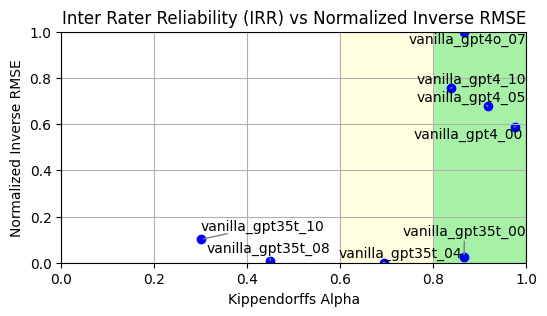

In [32]:
from adjustText import adjust_text

plt.figure(figsize=(6, 3))
plt.ylim(0,1)
plt.xlim(0,1)
plt.title('Inter Rater Reliability (IRR) vs Normalized Inverse RMSE')
plt.ylabel('Normalized Inverse RMSE')
plt.xlabel('Kippendorffs Alpha')
plt.grid(True)

plt.axvspan(0.8, 1, color='lightgreen', alpha=0.8, label='reliable')
plt.axvspan(0.6, 0.8, color='lightyellow', alpha=1, label='tentative')

plt.scatter(Summary['alpha'], Summary['RMSE_Inv_N'], color='blue')


# # Annotate points with the model names
# for idx, row in Summary.iterrows():
#         plt.annotate(idx, (row['alpha'], row['Accuracy']), textcoords="offset points", xytext=(0, 10), ha='center')

# Annotate points with the model names
texts = []
for idx, row in Summary.iterrows():
    texts.append(plt.text(row['alpha'], row['RMSE_Inv_N'], idx))

# Adjust text to avoid overlapping
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))


In [ ]:
# MSE
name = 'RMSE_H11' # Define Name
test_evaluators = filter_names(info_dict, model_type='vanilla', model = None, temperature=1) # select evaluators for  test



vanilla_gpt4_10_stats = stats('vanilla_gpt4_10')
vanilla_filtered = vanilla_gpt4_10_stats[vanilla_gpt4_10_stats.index.isin(core_texts)]['mean']

root_mean_squared_error(vanilla_filtered, human_core_stats['score_mean_w'])
#mean_absolute_error(vanilla_filtered, human_filtered)

# Archive

### Score Consistency / Agreement
- Descriptive statistics
- Standard deviations per text --> analysis of texts with highest standard deviations
- Standard deviations and scatterplot per final 'true' score --> is there higher disagreement at certain scores?
- Krippendorfs alpha for disagreement of multiple raters
- Cronbachs Alpha to account for systematic variations --> ignoring systematic differences between different raters
- Alpha, Scott's pi, and Pearson's original intraclass correlation --> assuming interchangeable coders

- reliability vs validity of llm evaluators

### Additional Analysies (optional)
- Time and Cost Analysis
- Characteristics Analysis
- Sentiment Analysis of reasons

### Definitions

In [ ]:
# # Define variables ##TODO: remove
# evaluators_human = ['humans', 'students', 'experts']
# cutoff = 1 # set std cutoff for texts to be categorized as ambiguous
# cutoff_llm = 0.5 # set std cutoff for texts to be categorized as ambiguous for LLMs

# # additional definitions
# evaluators = evaluators_human + evaluators_llm

In [ ]:
# # create subsets excluding ambiguous texts for each evaluator ##TODO: remove
# for i, evaluator in enumerate(evaluators_human):
#     data = globals()[evaluator]
#     globals()[evaluator + '_disagree'] = data.loc[data['std'] > cutoff].index # create a subset of the data excluding ambiguous texts
#     globals()[evaluator + '_agree'] = data.loc[globals()[evaluator + '_disagree']] # create a new dataframe for the subset

## LLM Evaluations

### Vanilla_GPT3.5_0.0

In [ ]:
data_transposed = vanilla_GPT35_0_scores.transpose() # transpose data
fleiss_data = aggregate_raters(data_transposed, n_cat=5) # aggregate so that each column shows how often a score was given
fleiss_kappa(fleiss_data[0], method='fleiss') # calculate Fleiss' Kappa

In [ ]:
vanilla_score(text = 'This is a test text', model = )

In [ ]:
# responses = data_raw[['Recorded']]

# # extract all fluff scores
# qualtrics = data_raw.filter(regex='\.3$|Q2.1') # extract all third Subquestions which are the human fluff scores
# question_nr = [int(x[1:-2]) for x in list(qualtrics.columns[1:])] # extract the question block numbers
# text_nr = [str(x-2) for x in question_nr] # create the corresponding text numbers
# qualtrics.columns = ['Expert'] + text_nr # rename columns
# qualtrics = qualtrics.apply(pd.to_numeric, errors='coerce') # convert to numeric
# qualtrics['Expert'] = qualtrics['Expert'].replace({1: False, 2: True}).astype(bool) # convert to boolean
# qualtrics.rename_axis('qualtrics', axis='columns', inplace=True)

# # delete helper data
# del drop_columns
# del question_nr
# del text_nr
# del data_raw

# qualtrics


# prepare human evaluations --> humans, experts, students
# prepare expert scores
students = qualtrics.loc[qualtrics['Expert'] == False].drop(columns='Expert').reset_index(drop=True) # subset for students and drop the expert column
students_stats = students.describe().transpose()[['mean', 'std', 'count']].round(2).rename_axis('T') # calculate stats for students
students_stats['score'] = students_stats['mean'].round(0) # create a score column
students_stats.index = students_stats.index.astype(int) # convert index to int
students = students.rename_axis('score').rename_axis('T', axis='columns') # rename axes
students = students.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
students = students.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
students = students.merge(students_stats, left_index=True, right_index=True, how='left').rename_axis('students', axis='columns') # merge with the stats

# prepare expert scores
experts = qualtrics.loc[qualtrics['Expert'] == True].drop(columns='Expert').reset_index(drop=True) # subset for experts and drop the expert column
experts_stats = experts.describe().transpose()[['mean', 'std', 'count']].round(0).rename_axis('T') # calculate stats for experts
experts_stats['score'] = experts_stats['mean'].round(2) # create a score column
experts_stats.index = experts_stats.index.astype(int) # convert index to int
experts = experts.rename_axis('score').rename_axis('T', axis='columns') # rename axes
experts = experts.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
experts = experts.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
experts = experts.merge(experts_stats, left_index=True, right_index=True, how='left').rename_axis('experts', axis='columns') # merge with the stats

# prepare human scores
humans = qualtrics.drop(columns='Expert').reset_index(drop=True) # subset for humans and drop the expert column
humans_stats = humans.describe().transpose()[['mean', 'std', 'count']].round(0).rename_axis('T') # calculate stats for humans
humans_stats['score'] = humans_stats['mean'].round(2) # create a score column
humans_stats.index = humans_stats.index.astype(int) # convert index to int
humans = humans.rename_axis('score').rename_axis('T', axis='columns') # rename axes
humans = humans.melt(value_name='score').dropna().reset_index(drop=True).astype(int).groupby(['T', 'score']).size().unstack(fill_value=0) # melt and groupby to get the counts of each score for each text
humans = humans.reindex(columns=[1,2,3,4,5], fill_value=0) # reindex to include all possible scores
humans = humans.merge(humans_stats, left_index=True, right_index=True, how='left').rename_axis('humans', axis='columns') # merge with the stats

# delete helperdata
del students_stats
del experts_stats
del humans_stats

students

### Score Correlation Analysis - Archive

In [ ]:
# visualize the scores
# Create a single set of axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each score series as a line
text_data['Student Score'].plot(kind='line', ax=ax, label='Student Score', marker='o')
text_data['Expert Score'].plot(kind='line', ax=ax, label='Expert Score', marker='o')
# text_data['Vanilla_GPT3.5_0.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT3.5_0.0_score', marker='o')
text_data['Vanilla_GPT3.5_1.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT3.5_1.0_score', marker='o')
# text_data['Vanilla_GPT4o_1.0_score'].plot(kind='line', ax=ax, label='Vanilla_GPT4o_1.0_score', marker='o')


# Add title and labels
ax.set_title('Fluff Scores Comparison')
ax.set_xlabel('Text Number') 
ax.set_ylabel('Score')

# Ensure x-axis shows values from the T column
ax.set_xticks(range(len(text_data['T'])))
ax.set_xticklabels(text_data['T'])

# Add a legend to differentiate the lines
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Score agreements using Cohen's Kappa
from sklearn.metrics import cohen_kappa_score

# calculate Cohen's Kappa between student and expert fluff scores
kappa_se = cohen_kappa_score(text_data['Student Score'], text_data['Expert Score'])
print(f'Cohen\'s Kappa between Student and Expert Scores: {kappa_se:.2f}')

# calculate Cohen's Kappa between student and Vanilla fluff scores
kappa_sv = cohen_kappa_score(text_data['Student Score'], text_data['Vanilla_GPT3.5_0.0_score'])
print(f'Cohen\'s Kappa between Student and Vanilla Scores: {kappa_sv:.2f}')

# calculate Cohen's Kappa between expert and Vanilla fluff scores
kappa_ev = cohen_kappa_score(text_data['Expert Score'], text_data['Vanilla_GPT3.5_0.0_score'])
print(f'Cohen\'s Kappa between Expert and Vanilla Scores: {kappa_ev:.2f}')



In [ ]:
# score agreements using Spearman's Rank Correlation
from scipy.stats import spearmanr

# calculate Spearman's Rank Correlation between student and expert fluff scores
spearman_se = spearmanr(text_data['Student Score'], text_data['Expert Score'])
print(f'Spearman\'s Rank Correlation between Student and Expert Scores: {spearman_se.correlation:.2f} with p-value: {spearman_se.pvalue:.2f}')

# calculate Spearman's Rank Correlation between student and Vanilla fluff scores
# spearman_sv = spearmanr(text_data['Student Score'], text_data['Vanilla_GPT3.5_0.0_score'])
# print(f'Spearman\'s Rank Correlation between Student and Vanilla Scores: {spearman_sv.correlation:.2f} with p-value: {spearman_sv.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
# spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT3.5_0.0_score'])
# print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT3.5_0.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT3.5_1.0_score'])
print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT3.5_1.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')

# calculate Spearman's Rank Correlation between expert and Vanilla fluff scores
# spearman_ev = spearmanr(text_data['Expert Score'], text_data['Vanilla_GPT4o_1.0_score'])
# print(f'Spearman\'s Rank Correlation between Expert and Vanilla_GPT4o_1.0_score: {spearman_ev.correlation:.2f} with p-value: {spearman_ev.pvalue:.2f}')


In [ ]:
mse_ev = ((text_data['Vanilla_GPT3.5_1.0_score'] - text_data['Expert Score'])**2).mean()
print(f'Mean Squared Error between Expert and Vanilla_GPT3.5_1.0_score: {mse_ev:.2f}')

mae_ev = (text_data['Vanilla_GPT3.5_1.0_score'] - text_data['Expert Score'].abs()).mean()
print(f'Mean Absolute Error between Expert and Vanilla_GPT3.5_1.0_score: {mae_ev:.2f}')

In [ ]:
accuracy_ev = accuracy_score(text_data['Expert Score'], text_data['Vanilla_GPT3.5_1.0_score'].round())
print(f'Accuracy between Expert and Vanilla_GPT3.5_1.0_score: {accuracy_ev:.2f}')